In [2]:
import catboost
print(catboost.__version__)

1.2.5


## 1. RFE→の順番で設定しグリットサーチでトレーニングする
クラスの割合が均等な場合はRFEを最初に適用します。

Model used the following features:
['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'Age_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'TypeofContact_Company Invited', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster', 'Product_Designation_Target_Encoding']
Fitting 30 folds for each of 48 candidates, totalling 1440 fits
Best parameters found: {'border_count': 32, 'depth': 2, 'iterations': 200, 'l2_leaf_reg': 50, 'learning_rate': 0.005, 'subsample': 0.8}
Best cross-validation AUC: 0.7983910
Cross-Validation AUC Scores: [0.78       0.7        0.69833333 0.85666667 0.85833333 0.91679507
 0.81510015 0.82588598 0.89830508 0.82588598 0.74114022 0.78120185
 0.74576271 0.74268105 0.90600924 0.7781201

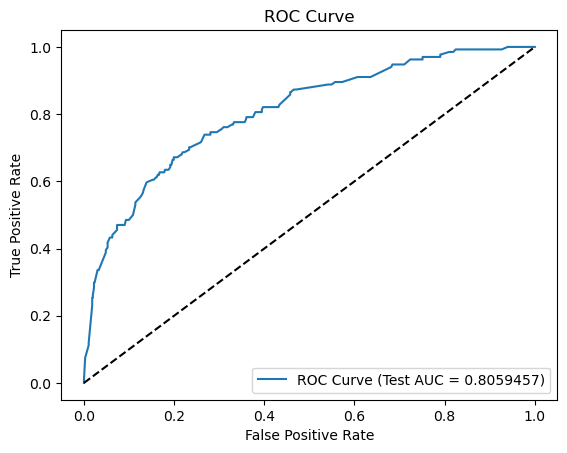

最適なCatBoostモデルが /Users/hayakawakazue/Downloads/signate/model/catboost_0828_1.joblib に保存されました。
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.850613154960981
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      1.00      0.92       763
     Class 1       0.00      0.00      0.00       134

    accuracy                           0.85       897
   macro avg       0.43      0.50      0.46       897
weighted avg       0.72      0.85      0.78       897



In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# CatBoostモデルを定義する(random_stateではなく、random_seedを使う）
cb_model = CatBoostClassifier(random_seed=22, eval_metric='AUC', verbose=0)

# RFEを使用して重要な特徴量を選択
selector = RFE(cb_model, n_features_to_select=22)
selector.fit(X_train, y_train)

# 使用した特徴量をプリント
selected_feature_names = X_train.columns[selector.support_]
print("Model used the following features:")
print(selected_feature_names.tolist())

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# RFE後のCatBoostモデルを再定義（リセット）
cat_model_selected = CatBoostClassifier(random_seed=22, eval_metric='AUC', verbose=0)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=22)

# グリッドサーチの設定を再調整
param_grid = {
    'iterations': [50, 100, 200],
    'depth': [1, 2],
    'learning_rate': [0.001, 0.005],
    'l2_leaf_reg': [50, 100],
    'border_count': [16, 32],
    'subsample': [0.8]
}

#グリッドサーチを設定
cb_grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行（早期終了はここでは設定しない）
cb_grid_search.fit(X_train_selected, y_train)

# 最適なモデルを取得
cb_best = cb_grid_search.best_estimator_

# 最適なモデルに対して早期終了を設定して再トレーニング
cb_best.fit(X_train_selected, y_train, early_stopping_rounds=5, eval_set=(X_test_selected, y_test), verbose=0)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {cb_grid_search.best_score_:.7f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(cb_best, X_train_selected, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = cb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_0828_1.joblib')
joblib.dump(cb_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cb_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## 2. SMOTE→RFEの順に設定してグリッドサーチでトレーニング（非奨励）
サンプルの数が不均等になっている場合、有効になる可能性があります。しかし、過学習になる可能性が非常に高いです。

Model used the following features:
['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Age_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Designation_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Product_Designation_Target_Encoding']
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'border_count': 32, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 10, 'learning_rate': 0.05, 'subsample': 0.8}
Best cross-validation AUC: 0.9645263
Cross-Validation AUC Scores: [0.86121399 0.85788714 0.99610822 0.98967422 0.99725413 0.99476076
 0.99646509 0.99611791 0.99536043 0.99839035]
Mean Cross-Validation AUC: 0.9683232253700826
Test AUC: 0.795470749371458

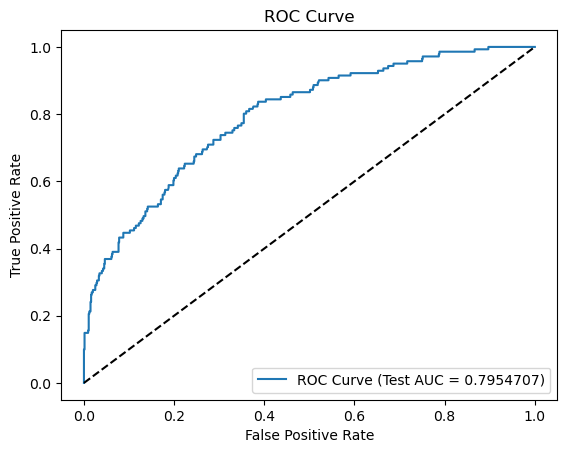

最適なCatBoostモデルが /Users/hayakawakazue/Downloads/signate/model/catboost_0822_1.joblib に保存されました。
Precision: 0.4114285714285714
Recall: 0.5106382978723404
F1 Score: 0.45569620253164556
Accuracy: 0.8082497212931996
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.86      0.88       756
     Class 1       0.41      0.51      0.46       141

    accuracy                           0.81       897
   macro avg       0.66      0.69      0.67       897
weighted avg       0.83      0.81      0.82       897



In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# カテゴリカルフィーチャーのインデックスを取得 
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

# トレーニングデータの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train_clean = X_train.loc[train_indices]
y_train_clean = y_train.loc[train_indices]

# テストデータの前処理：nanを含む行を削除し、対応する y も削除
test_indices = X_test.dropna().index
X_test_clean = X_test.loc[test_indices]
y_test_clean = y_test.loc[test_indices]

# SMOTEを適用してクラス不均衡を解消
smote = SMOTE(random_state=25)
X_train_smote, y_train_smote = smote.fit_resample(X_train_clean, y_train_clean)

# RFE前にカテゴリカルフィーチャーのインデックスを取得 
cat_feature_indices = np.where(X.dtypes == 'object')[0]  # RFE前に取得

# CatBoostモデルのインスタンスを作成（カテゴリカルフィーチャーを適用）
cb_model = CatBoostClassifier(random_seed=26, eval_metric='AUC', verbose=0)

# RFEを使用して重要な特徴量を選択
selector = RFE(cb_model, n_features_to_select=20)
selector.fit(X_train_smote, y_train_smote)

# RFEで選択された特徴量を使用
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test_clean)

# 使用した特徴量をプリント
selected_feature_names = X_train_clean.columns[selector.support_]
print("Model used the following features:")
print(selected_feature_names.tolist())

# RFE後にカテゴリカルフィーチャーを再設定
cat_features_selected = [i for i in range(X_train_selected.shape[1]) if i in cat_feature_indices]

# CatBoostモデルのインスタンスを再作成（カテゴリカルフィーチャーを適用）
cb_model = CatBoostClassifier(random_seed=26, eval_metric='AUC', cat_features=cat_features_selected, verbose=0)

# グリッドサーチの設定を再調整
param_grid = {
    'iterations': [100, 150, 200],
    'depth': [3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'l2_leaf_reg': [10, 20],
    'border_count': [32],
    'subsample': [0.8, 1.0]
}

# グリッドサーチの設定
cb_grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
cb_grid_search.fit(X_train_selected, y_train_smote)

# 最適なモデルを取得
cb_best = cb_grid_search.best_estimator_

# 最適なモデルに対して早期終了を設定して再トレーニング
cb_best.fit(X_train_selected, y_train_smote, early_stopping_rounds=10, eval_set=(X_test_selected, y_test_clean), verbose=0)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {cb_grid_search.best_score_:.7f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(cb_best, X_train_smote, y_train_smote, cv=10, scoring='roc_auc')  # SMOTE適用後のデータセットを使用
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = cb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test_clean, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test_clean, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_0822_1.joblib')
joblib.dump(cb_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cb_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test_clean, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test_clean, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test_clean, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test_clean, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test_clean, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## 3.RFE→SMOTEの順番で設定しランダムサーチでトレーニングする

Selected features: Index(['NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize',
       'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch',
       'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank',
       'Designation_Rank', 'Income_Bucket_Rank',
       'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited',
       'Gender_Female', 'CityTier_Age_Income_Interaction',
       'FamilySize_Income_Interaction', 'EngagementScore',
       'ProductPitched_Satisfaction', 'Cluster_ProdTaken_Ratio',
       'Product_Designation_Target_Encoding'],
      dtype='object')
Fitting 10 folds for each of 50 candidates, totalling 500 fits
0:	test: 0.7555209	best: 0.7555209 (0)	total: 1.08ms	remaining: 324ms
10:	test: 0.8239093	best: 0.8239093 (10)	total: 11.3ms	remaining: 297ms
20:	test: 0.8191707	best: 0.8239093 (10)	total: 20.7ms	remaining: 275ms
30:	test: 0.8235655	best: 0.8239093 (10)	t

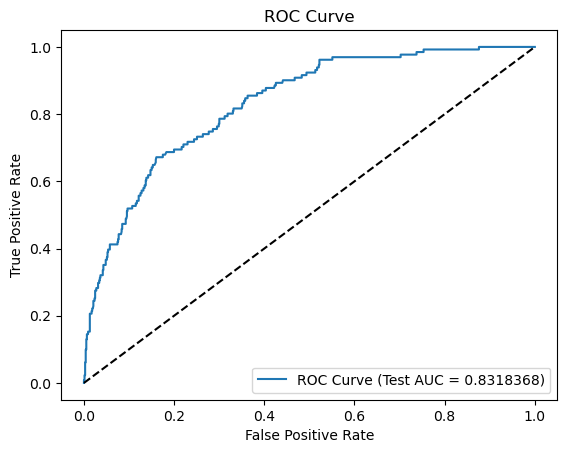

最適なCatBoostモデルが /Users/hayakawakazue/Downloads/signate/model/catboost_best_random0821_12.joblib に保存されました。
Precision: 0.34572490706319703
Recall: 0.7099236641221374
F1 Score: 0.465
Accuracy: 0.7614269788182831
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.77      0.85       766
     Class 1       0.35      0.71      0.47       131

    accuracy                           0.76       897
   macro avg       0.64      0.74      0.66       897
weighted avg       0.85      0.76      0.79       897



In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# カテゴリカルフィーチャーのインデックスを取得
cat_feature_indices = np.where(X.dtypes == 'object')[0]

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train_clean = X_train.loc[train_indices]
y_train_clean = y_train.loc[train_indices]

test_indices = X_test.dropna().index
X_test_clean = X_test.loc[test_indices]
y_test_clean = y_test.loc[test_indices]

# CatBoostモデルのインスタンスを作成
cb_model = CatBoostClassifier(random_seed=18, eval_metric='AUC', cat_features=cat_feature_indices, verbose=0)

# RFEを使用して重要な特徴量を選択
selector = RFE(cb_model, n_features_to_select=23)
selector.fit(X_train_clean, y_train_clean)

# 選択された特徴量の確認
selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features}")

# 選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train_clean)
X_test_selected = selector.transform(X_test_clean)

# RFE後にカテゴリカルフィーチャーを再設定
cat_features_selected = [i for i in range(X_train_selected.shape[1]) if selector.support_[i] and i in cat_feature_indices]

# SMOTEでトレーニングデータの不均衡を解消
smote = SMOTE(random_state=27)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train_clean)

# CatBoostモデルのインスタンスを再作成
cb_model = CatBoostClassifier(random_seed=18, eval_metric='AUC', cat_features=cat_features_selected, verbose=0)

# 最適なハイパーパラメータの候補を設定
param_dist = {
    'iterations': [100, 200, 300],
    'depth': [2, 3],
    'learning_rate': [0.001, 0.005],
    'l2_leaf_reg': [10, 15],
    'border_count': [32, 64, 128],
    'subsample': [0.2, 0.25]
}

# ランダムサーチの設定
cb_random_search = RandomizedSearchCV(estimator=cb_model, param_distributions=param_dist, n_iter=50, cv=10, scoring='roc_auc',
                                      n_jobs=-1, verbose=1, random_state=18)

# ランダムサーチの実行
cb_random_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
cb_best = cb_random_search.best_estimator_

# 最適なモデルに対して早期終了を設定してモデルを再トレーニング
cb_best.fit(X_train_smote, y_train_smote, eval_set=(X_test_selected, y_test_clean), early_stopping_rounds=50, verbose=10)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cb_random_search.best_params_}")
print(f"Best cross-validation AUC: {cb_random_search.best_score_:.7f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(cb_best, X_train_selected, y_train_clean, cv=10, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = cb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test_clean, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test_clean, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_best_random0821_12.joblib')
joblib.dump(cb_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cb_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test_clean, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test_clean, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test_clean, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test_clean, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test_clean, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## 4.モデルが重視する特徴量を可視化する

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found: {'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 8, 'border_count': 64}
Best cross-validation AUC: 0.8290
Test AUC: 0.8020414114902302
Model's most important features (Top 25):
                                    Feature  Importance
21                         Designation_Rank    8.845233
7                                  Passport    6.504579
32                              Gender_Male    6.498654
20                      ProductPitched_Rank    6.334538
36                 Designation_PropertyStar    5.757054
1                                  CityTier    4.131752
40                Pitch_Effectiveness_Index    3.335670
9                             MonthlyIncome    2.845669
22                       Income_Bucket_Rank    2.766080
2                           DurationOfPitch    2.761221
5                     PreferredPropertyStar    2.760864
39            Family_Income_Stability_Index 

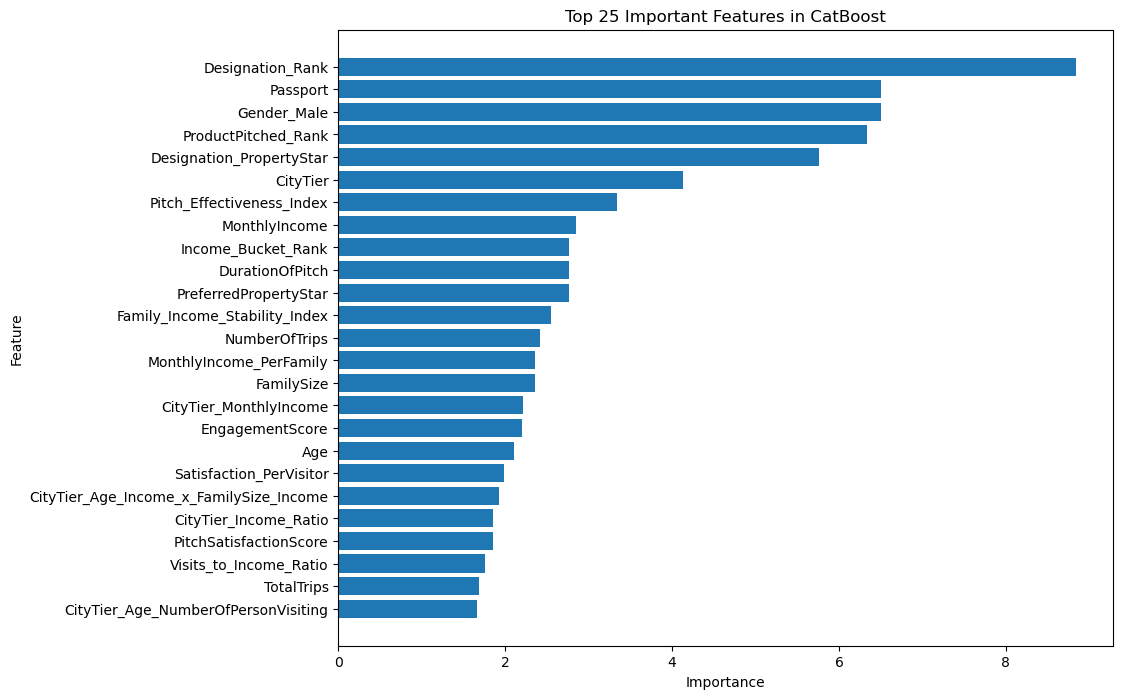

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils import compute_sample_weight
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

# サンプルの重みを計算
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# CatBoostモデルの定義
catboost_model = CatBoostClassifier(verbose=0, random_seed=17)

# ハイパーパラメータの候補を設定
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128]
}

# ランダムサーチの設定
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
catboost_random_search = RandomizedSearchCV(estimator=catboost_model, param_distributions=param_dist, n_iter=10, cv=skf, 
                                            scoring='roc_auc', n_jobs=-1, verbose=1, random_state=17)

# ランダムサーチの実行（重み付けを適用）
catboost_random_search.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {catboost_random_search.best_params_}")
print(f"Best cross-validation AUC: {catboost_random_search.best_score_:.4f}")

# 最適なモデルを取得
catboost_best = catboost_random_search.best_estimator_

# 最適なモデルを使用して再トレーニング（重み付けを適用）
catboost_best.fit(X_train, y_train, sample_weight=sample_weight)

# テストデータでの予測とAUC計算
y_pred_proba = catboost_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 重要度の取得と上位20の特徴量を可視化
importance = catboost_best.get_feature_importance()
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(25)

# 重要な特徴量のリストを表示
print("Model's most important features (Top 25):")
print(importance_df)

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Important Features in CatBoost')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()

## 特徴量を選択しグリッドサーチでトレーニング

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best parameters found: {'bagging_temperature': 0.2, 'border_count': 64, 'depth': 2, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
Best cross-validation AUC: 0.8167
Cross-Validation AUC Scores: [0.79592536 0.8219483  0.76553672 0.77242232 0.80384887 0.79378531
 0.79149011 0.84110169 0.82132768 0.89018362]
Mean Cross-Validation AUC: 0.8097569979455572
Test AUC: 0.7917776970284238
過学習の可能性があります: Cross-Validation AUCがTest AUCを0.0179793だけ上回っています。


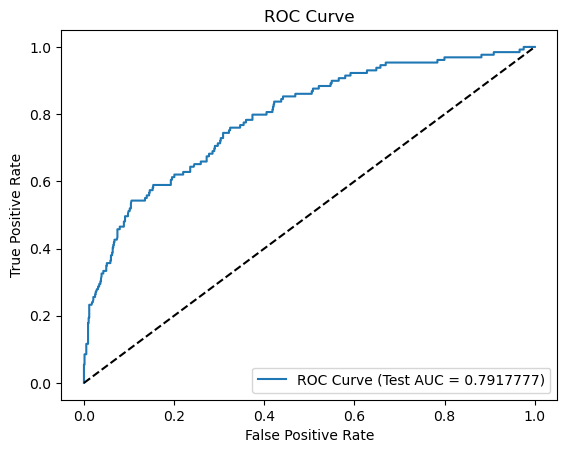

最適なCatBoostモデルが /Users/hayakawakazue/Downloads/signate/model/catboost_grid_0901_12.joblib に保存されました。
Precision: 0.29
Recall: 0.6744186046511628
F1 Score: 0.40559440559440557
Accuracy: 0.7157190635451505
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.72      0.81       768
     Class 1       0.29      0.67      0.41       129

    accuracy                           0.72       897
   macro avg       0.61      0.70      0.61       897
weighted avg       0.84      0.72      0.75       897



In [9]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from sklearn.utils import compute_sample_weight
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Designation_Rank', 'Passport', 'Gender_Male', 
    'ProductPitched_Rank', 'Designation_PropertyStar', 'CityTier', 'Pitch_Effectiveness_Index', 
    'MonthlyIncome', 'Income_Bucket_Rank', 'DurationOfPitch',
    'PreferredPropertyStar', 'Family_Income_Stability_Index', 'NumberOfTrips',
    'MonthlyIncome_PerFamily', 'FamilySize', 'CityTier_MonthlyIncome',
    'EngagementScore', 'Age', 'Satisfaction_PerVisitor',
    'CityTier_Age_Income_x_FamilySize_Income'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =15)

# サンプルの重みを計算
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# トレインデータの前処理：nanを含む行を削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]

# テストデータの前処理：nanを含む行を削除
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# CatBoostモデルのインスタンスを作成（モデルの定義）
cb_model = CatBoostClassifier(random_seed=15, eval_metric='AUC', verbose=0)

# ハイパーパラメータの候補を設定
param_grid = {
    'iterations': [50, 100],
    'depth': [1, 2],
    'learning_rate': [0.001, 0.01],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'bagging_temperature': [0.2, 0.5]
}

# skfの設定
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

# グリッドサーチの設定
cat_grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=skf, 
                               scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
cat_grid_search.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なモデルを取得
cat_best = cat_grid_search.best_estimator_

# 最適なモデルを使用して再トレーニング（重み付けを適用）
cat_best.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cat_grid_search.best_params_}")
print(f"Best cross-validation AUC: {cat_grid_search.best_score_:.4f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(cat_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = cat_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_grid_0901_12.joblib')
joblib.dump(cat_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cat_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## 5-2. CatBoosting| Select features→SMOTE→GridSearch→Crossvalidation
以下のコードでは、Pipelineを使用して、SMOTEをクロスバリデーションの一部として処理しています。

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found: {'model__bagging_temperature': 0.2, 'model__border_count': 64, 'model__depth': 6, 'model__iterations': 300, 'model__l2_leaf_reg': 9, 'model__learning_rate': 0.05}
Best cross-validation AUC: 0.8026
Test AUC: 0.817704675309884
過学習の兆候は見られません。


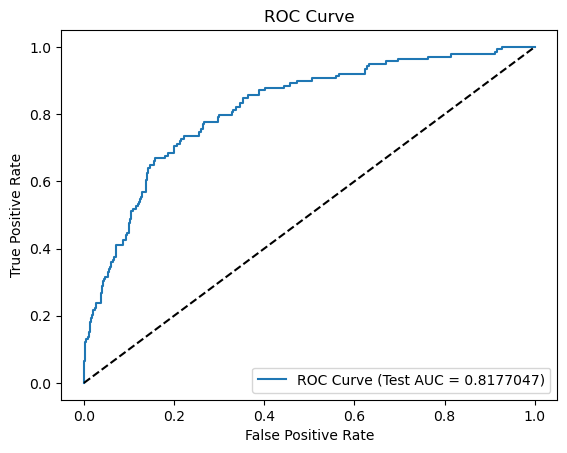

最適なCatBoostモデルが /Users/hayakawakazue/Downloads/signate/model/catboost_select_futures_0826_grid.joblib に保存されました。
Precision: 0.5274725274725275
Recall: 0.34532374100719426
F1 Score: 0.41739130434782606
Accuracy: 0.850613154960981
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       758
     Class 1       0.53      0.35      0.42       139

    accuracy                           0.85       897
   macro avg       0.71      0.64      0.67       897
weighted avg       0.83      0.85      0.84       897



In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Product_Designation_Target_Encoding', 'Designation_Rank', 'Income_Bucket_Rank',
    'CityTier_Age_Income_Interaction', 'Age_ProdTaken_Mean', 'Passport',
    'Age_MonthlyIncome_Interaction', 'Gender_Female', 'EngagementScore',
    'NumberOfFollowups', 'Satisfaction_PerVisitor', 'FamilySize_Income_Interaction', 
    'PreferredPropertyStar', 'Income_Per_Age','NumberOfTrips',
    'DurationOfPitch_Category_Rank', 'NumberOfPersonVisiting', 'ProductPitched_Satisfaction',
    'Cluster', 'Age_DurationOfPitch', 'Cluster_ProdTaken_Ratio',
    'Income_ProdTaken_Mean', 'MaritalStatus'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# SMOTEとモデルをPipelineにまとめる
pipeline = Pipeline([
    ('smote', SMOTE(random_state=10)),
    ('model', CatBoostClassifier(random_seed=30, eval_metric='AUC', verbose=0))
])

# ハイパーパラメータの範囲を設定
param_grid = {
    'model__iterations': [100, 300, 500],  # 少し多めに設定
    'model__depth': [4, 5, 6],  # 深さを増やして検討
    'model__learning_rate': [0.01, 0.05],
    'model__l2_leaf_reg': [3, 5, 7, 9],
    'model__border_count': [32, 64],
    'model__bagging_temperature': [0.2, 0.5]
}

# StratifiedKFoldを使用したクロスバリデーションの設定
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

# グリッドサーチの設定
cat_grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=stratified_kfold, scoring='roc_auc', 
                               n_jobs=-1, verbose=1)
# グリッドサーチの実行
cat_grid_search.fit(X_train, y_train)

# 最適なモデルを取得
cat_best = cat_grid_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cat_grid_search.best_params_}")
print(f"Best cross-validation AUC: {cat_grid_search.best_score_:.4f}")

# テストデータでの予測とAUC計算
y_pred_proba = cat_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無を確認
cv_scores = cat_grid_search.cv_results_['mean_test_score']
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_select_futures_0826_grid.joblib')
joblib.dump(cat_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cat_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


In [2]:
import pandas as pd

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# NaNを含む行の数を確認
nan_rows = train_data.isnull().sum().sum()

if nan_rows > 0:
    print(f"データセットには {nan_rows} 個のNaN値が含まれています。")
else:
    print("データセットにNaN値は含まれていません。")


データセットにNaN値は含まれていません。


## 特徴量を選択しグリッドサーチでトレーニングする

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
0:	test: 0.7496063	best: 0.7496063 (0)	total: 2ms	remaining: 599ms
10:	test: 0.7931127	best: 0.7931127 (10)	total: 10.4ms	remaining: 274ms
20:	test: 0.7950423	best: 0.7997667 (14)	total: 18.6ms	remaining: 247ms
30:	test: 0.7962623	best: 0.7997667 (14)	total: 27.2ms	remaining: 236ms
40:	test: 0.7999417	best: 0.8001507 (38)	total: 37.8ms	remaining: 239ms
50:	test: 0.8018616	best: 0.8018616 (50)	total: 44.5ms	remaining: 217ms
60:	test: 0.8062992	best: 0.8062992 (60)	total: 51.7ms	remaining: 203ms
70:	test: 0.8089336	best: 0.8089725 (68)	total: 59.5ms	remaining: 192ms
80:	test: 0.8096675	best: 0.8097745 (79)	total: 66.4ms	remaining: 180ms
90:	test: 0.8113882	best: 0.8113882 (90)	total: 73.2ms	remaining: 168ms
100:	test: 0.8136920	best: 0.8136920 (100)	total: 80ms	remaining: 158ms
110:	test: 0.8151307	best: 0.8154224 (108)	total: 87.5ms	remaining: 149ms
120:	test: 0.8174541	best: 0.8174541 (120)	total: 95ms	remaining: 140ms
13

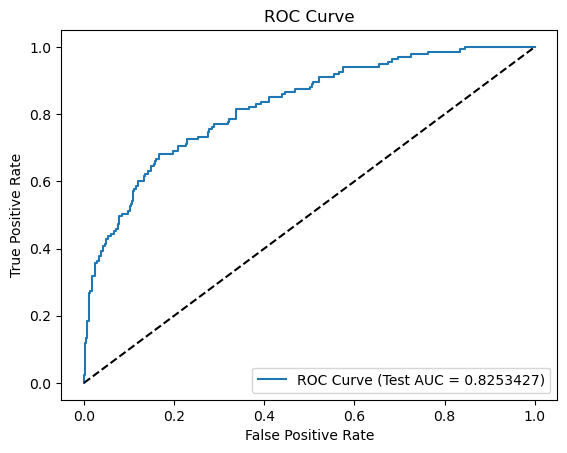

最適なCatBoostモデルが /Users/hayakawakazue/Downloads/signate/model/catboost_select_futures_0830_grid.joblib に保存されました。
Precision: 0.35379061371841153
Recall: 0.725925925925926
F1 Score: 0.47572815533980584
Accuracy: 0.7591973244147158
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.77      0.84       762
     Class 1       0.35      0.73      0.48       135

    accuracy                           0.76       897
   macro avg       0.65      0.75      0.66       897
weighted avg       0.85      0.76      0.79       897



In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Designation_Rank', 'Product_Designation_Target_Encoding', 'FamilySize',
    'MaritalStatus', 'Income_Bucket_Rank', 'Passport', 
    'Age_MonthlyIncome_Interaction', 'Occupation_Large_Business', 'Gender_Female',
    'EngagementScore', 'Cluster_ProdTaken_Ratio', 'NumberOfTrips',
    'TypeofContact_Company_Invited', 'Occupation_Salaried', 'Age_ProdTaken_Mean',
    'ProductPitched_Satisfaction', 'Satisfaction_PerVisitor', 'ProductPitched_Rank',
    'CityTier_Age_Income_x_FamilySize_Income', 'PreferredPropertyStar'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31, stratify=y)

# クラスの比率からscale_pos_weightを計算する
neg, pos = np.bincount(y_train)
scale_pos_weight = neg/pos

# CatBoostモデルのインスタンスを作成
cb_model = CatBoostClassifier(random_seed=31, eval_metric='AUC', verbose=0)

# ハイパーパラメータの候補を設定
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [2, 3],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'bagging_temperature': [0.2, 0.5],
    'scale_pos_weight': [scale_pos_weight]
}

# StratifiedKFoldを設定
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=31)

# グリッドサーチの設定
cat_grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=skf, scoring='roc_auc', 
                               n_jobs=-1, verbose=1)

# グリッドサーチの実行
cat_grid_search.fit(X_train, y_train)

# 最適なモデルを取得
cat_best = cat_grid_search.best_estimator_

# 最適なモデルに対して早期終了を設定してモデルを再トレーニング
cat_best.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=10)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cat_grid_search.best_params_}")
print(f"Best cross-validation AUC: {cat_grid_search.best_score_:.4f}")

# StratifiedKFoldを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(cat_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = cat_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_select_futures_0830_grid.joblib')
joblib.dump(cat_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cat_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## 6.特徴量を選択しランダムサーチでトレーニングする
StratifiedKFoldを使用したクロスバリデーションの設定

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Product_Designation_Target_Encoding', 'Designation_Rank', 'Income_Bucket_Rank',
    'CityTier_Age_Income_Interaction', 'Age_ProdTaken_Mean', 'Passport',
    'Age_MonthlyIncome_Interaction', 'Gender_Female', 'EngagementScore',
    'NumberOfFollowups', 'Satisfaction_PerVisitor', 'FamilySize_Income_Interaction', 
    'PreferredPropertyStar', 'Income_Per_Age','NumberOfTrips',
    'DurationOfPitch_Category_Rank', 'NumberOfPersonVisiting', 'ProductPitched_Satisfaction',
    'Cluster', 'Age_DurationOfPitch', 'Cluster_ProdTaken_Ratio',
    'Income_ProdTaken_Mean', 'MaritalStatus'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
# クラスの比率からscale_pos_weightを計算する
neg, pos = np.bincount(y_train)
scale_pos_weight = neg/pos


# ハイパーパラメータの範囲を設定
param_grid = {
    'model__iterations': [100, 300, 500],  # 少し多めに設定
    'model__depth': [4, 5, 6],  # 深さを増やして検討
    'model__learning_rate': [0.01, 0.05],
    'model__l2_leaf_reg': [3, 5, 7, 9],
    'model__border_count': [32, 64],
    'model__bagging_temperature': [0.2, 0.5]
}

# StratifiedKFoldを使用したクロスバリデーションの設定
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=18)

# ランダムサーチの設定
cat_random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, 
                                       n_iter=50, cv=stratified_kfold, scoring='roc_auc', 
                                       n_jobs=-1, random_state=18, verbose=1)

# ランダムサーチの実行
cat_random_search.fit(X_train_smote, y_train_smote)  # SMOTE適用後のデータでフィッティング

# 最適なモデルを取得
cat_best = cat_random_search.best_estimator_

# 最適なモデルに対して早期終了を設定して再トレーニング
cat_best.fit(X_train_smote, y_train_smote, early_stopping_rounds=10, eval_set=(X_test, y_test), verbose=0)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {cat_random_search.best_params_}")
print(f"Best cross-validation AUC: {cat_random_search.best_score_:.7f}")

# テストデータでの予測とAUC計算
y_pred_proba = cat_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無を確認する
if cat_random_search.best_score_ > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cat_random_search.best_score_ - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'catboost_random0826.joblib')
joblib.dump(cat_best, model_path)
print(f"最適なCatBoostモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = cat_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


NameError: name 'param_dist' is not defined